# Geospatial BI & Data Viz Project - Part 2

- VISUALIZATION PROJECT Geospatial Business Intelligence (BI)
    * Make a geospatial analysis of the `companies` dataset
    * Things you know:
        - You have a software company with 50 employees
        - The company creates video games
        - Roles in your company: 20 developers, 20 Designers/Creatives/UX/UI and 10 executives/managers
    * Do an analysis about placing the new company offices in the best environment based on the following criteria:
        - There should be software engineers working around
        - The surroundings must have a good ratio of big companies vs startups
        - Ensure you have in your surroundings companies that cover the interests of your team
        - Avoid old companies, prefer recently created ones
        
JSON companies --> MongoDB --> Python:
Queries en Jupyter-Notebook --> DataFrame (Pandas) --> columna geopoint con diccionario con type = point y un array con formato array [lat,long]
indice geospatial (point) para volver a cargar en MongoDB y hacer nuevas queries (esta vez tocar la parte de queries geo-espaciales $near, etc...) 
por ej: de todos los puntos, dime el que está más cerca de empresas de videojuegos, o a 1000m
para tener el max y min, hay que probarlos todos 

In [84]:
# import pymongo to connect Python with MongoDB
from pymongo import MongoClient
# to work with stats
import pandas as pd
# to work with dataframes
import numpy as np
# to work with json
from pandas.io.json import json_normalize
# to plot
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns

### 1. Prepare the data: extract from the companies database the relevant information for the challenge.

* company identification
    - id (just in case we would need to get more information later)
    - name
* only currently active company
    - 'deadpooled_year' --> not none
    
* for geolocation analysis & geospatial visualization
    - offices.latitude, offices.longitude --> not null
    - offices.country_code, offices.city --> not null

* to determine if the company is old (negative) o recent (positive)
    - founded_year --> not null

* to define if it's a small (startup) or a big company:
    - number_of_employees --> company size (make sure there are not ficticious and have >= 1 employee)
    - investments.funding_round.round_code: 'Angel','seed' --> to associate to startup category
    https://support.crunchbase.com/hc/en-us/articles/115010458467-Glossary-of-Funding-Types
    - investments.funding_round.funded_year
    - ipo.pub_year,ipo.valuation_amount --> to associate with big company   

* to match with our team interests: technology & videogames
    - category_code: 'software', 'web', 'games_video' --> to filter as 'best match' for our team --> not null
    - description: 'software','technology', 'Platform','Social network' --> for a qualitative analysis
    - tag_list: 'network', 'online-communities','projects', etc --> for a qualitative analysis

In [85]:
# connecting on default host and port
client = MongoClient ('localhost', 27017)

# loading the database
db = client['companies']

# getting the collection
companies = db['companies']

# defining query to get the relevant information
query = db.companies.find({'$and':[{'founded_year':{'$ne': None}},{'category_code':{'$ne': None}},
{'deadpooled_year':None},{'number_of_employees':{'$gte':1}},{'offices.latitude':{'$ne':  None}},{'offices.longitude': {'$ne':  None}},
{'offices.country_code':{'$ne':  None}},{'offices.city':{'$ne':  None}}]},{'_id':1, 'name':1,'founded_year':1,'deadpooled_year':1, 
'number_of_employees':1,'offices.latitude':1,'offices.longitude':1,'offices.country_code':1,'offices.city':1,
'investments.funding_round.round_code':1,'investments.funding_round.funded_year':1,'ipo.pub_year':1,'ipo.valuation_amount':1,
'category_code':1,'description':1,'tag_list':1})

In [86]:
# we load our query to a dataframe to work with                           
def cursor_to_df(query):
    return pd.DataFrame(list(query))

data = cursor_to_df(query)

In [67]:
# checking we get all the requested info
data.columns

Index(['_id', 'category_code', 'deadpooled_year', 'description',
       'founded_year', 'investments', 'ipo', 'name', 'number_of_employees',
       'offices', 'tag_list'],
      dtype='object')

In [44]:
# checking what kind of variables we have
data.dtypes

_id                    object
category_code          object
deadpooled_year        object
description            object
founded_year            int64
investments            object
ipo                    object
name                   object
number_of_employees     int64
offices                object
tag_list               object
dtype: object

In [20]:
data.head()

,_id,category_code,deadpooled_year,description,founded_year,investments,ipo,name,number_of_employees,offices,tag_list
0,52cdef7c4bab8bd675297d8d,news,None,user driven social content website,2004,[],NaN,Digg,60,"[{'city': 'San Francisco', 'country_code': 'US...","community, social, news, bookmark, digg, techn..."
1,52cdef7c4bab8bd675297d91,web,None,Geneology social network site,2006,[],NaN,Geni,18,"[{'city': 'West Hollywood', 'country_code': 'U...","geni, geneology, social, family, genealogy"
2,52cdef7c4bab8bd675297d97,news,None,Read Unlimited Books,2007,[],NaN,Scribd,50,"[{'city': 'San Francisco', 'country_code': 'US...","book-subscription, digital-library, netflix-fo..."
3,52cdef7c4bab8bd675297d94,social,None,Real time communication platform,2006,[],"{'valuation_amount': 18100000000, 'pub_year': ...",Twitter,1300,"[{'city': 'San Francisco', 'country_code': 'US...","text, messaging, social, community, twitter, t..."
4,52cdef7c4bab8bd675297d8e,social,None,Social network,2004,"[{'funding_round': {'round_code': 'seed', 'fun...","{'valuation_amount': 104000000000, 'pub_year':...",Facebook,5299,"[{'city': 'Menlo Park', 'country_code': 'USA',...","facebook, college, students, profiles, network..."


In [68]:
# check all variables we ask without null have 100% data per register + all companies are currently active
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5727 entries, 0 to 5726
Data columns (total 11 columns):
_id                    5727 non-null object
category_code          5727 non-null object
deadpooled_year        0 non-null object
description            4065 non-null object
founded_year           5727 non-null int64
investments            5727 non-null object
ipo                    87 non-null object
name                   5727 non-null object
number_of_employees    5727 non-null int64
offices                5727 non-null object
tag_list               5633 non-null object
dtypes: int64(2), object(9)
memory usage: 492.2+ KB


### Working with bins for numerical variables which are decision parameters:

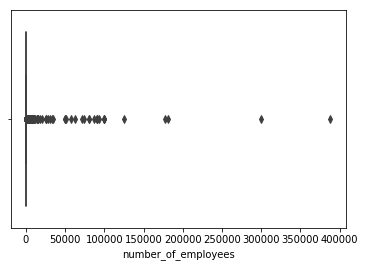

In [87]:
# looking for outliers first:
sns.boxplot(x=data['number_of_employees'])
# in this case we want a great ratio between big companies and start ups, it's preferible not to remove the big 4

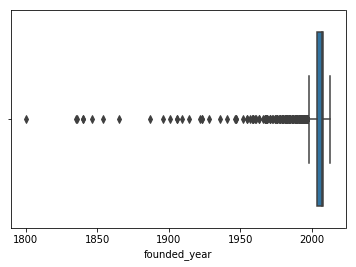

In [70]:
sns.boxplot(x=data['founded_year'])
# in this case we want to avoid old companies so it's not recommended to remove them from dataset

In [102]:
data_justforplot = data.where(data[['founded_year']>= 1900 & ['number_of_employees']<=150000]])

SyntaxError: invalid syntax (<ipython-input-102-d07f2f2bb556>, line 1)

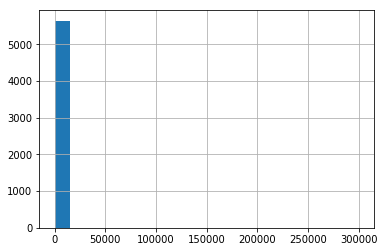

In [49]:
data_justforplot.number_of_employees.hist(bins=20) 

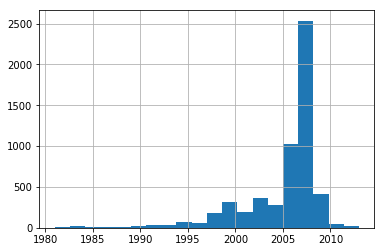

In [36]:
# First we have a look on these variables
data.founded_year.hist(bins=20)

In [114]:
# creating a function to apply bins with Q1,Q2,Q3 and Q4 and be able to automate when refreshing database
def bins_q4(var):
    cutoffs_tab = pd.DataFrame(df[var].describe(),index=['count','mean','std','min','q1','q2','median','q3','max'])
    bins_labels = ['q1','q2','q3','q4']
    cutoffs = [cutoffs_tab[var]['min'],cutoffs_tab[var]['q1'],cutoffs_tab[var]['q2'],cutoffs_tab[var]['q3'],cutoffs_tab[var]['max']]
    return pd.cut(df[var],cutoffs, labels=bins_labels)

In [115]:
# we apply it to founded year and number of employees:
data['founded_year_bins'] = bins_q4(data['founded_year'])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# defining bins: 1) old 2)from Google invention to 1st quartile & mean 3) medi-3rd quartil an 4) 3rd quartile-max

def founded_year_bins(var):
    pd.DataFrame(df[var].describe(),index=['count','mean','std','min','q1','q2','median','q3','max'])
    bins_labels = ['q1','q2','q3','q4']
    cutoffs = [1800,2000,2006,2013] 
    df['tempo_clas'] = pd.cut(df[var],cutoffs, labels=bins_labels)
    return df[['tempo','tempo_clas']].head()

In [ ]:
data.founded_year.value_counts()

In [ ]:
# Defining 'Startups': Less than 10 employees

In [ ]:
df = json_normalize (data=x, record_path=['offices'], meta=['name', 'category_code','number_of_employees','founded_year'], errors='ignore')

In [ ]:
# checking the data quantity for our analyse
data.shape

In [ ]:
data.category_code.value_counts()

In [ ]:
data.to_json(‘./companies.json’, orient=‘records’, lines=True)